In [22]:
import os, re, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.dpi'] = 140

# Heisenberg S=1/2 (T=0) reference for the z-component
m_heis = 0.307
ms2z_heis_T0 = (m_heis**2) / 3.0
print("Heisenberg T=0 reference m_s^2(z) ≈", ms2z_heis_T0)


Heisenberg T=0 reference m_s^2(z) ≈ 0.03141633333333333


In [23]:
# Search locally first, then /mnt/data/.
CANDS_SUMMARY    = [Path("summary.csv"), Path("results/summary.csv"), Path("/mnt/data/summary.csv"), Path("/mnt/data/results/summary.csv")]
CANDS_MS2_DNORM  = [Path("ms2_summary_dnorm.csv"), Path("/mnt/data/ms2_summary_dnorm.csv")]
CANDS_MS2        = [Path("ms2_summary.csv"), Path("/mnt/data/ms2_summary.csv")]
CANDS_COMBINED   = [Path("combined_S_q_mean.txt"), Path("/mnt/data/combined_S_q_mean.txt")]

p_summary   = next((p for p in CANDS_SUMMARY   if p.exists()), None)
p_ms2_dnorm = next((p for p in CANDS_MS2_DNORM if p.exists()), None)
p_ms2       = next((p for p in CANDS_MS2       if p.exists()), None)
p_combined  = next((p for p in CANDS_COMBINED  if p.exists()), None)

print("summary.csv (D)          :", p_summary)
print("ms2_summary_dnorm.csv     :", p_ms2_dnorm)
print("ms2_summary.csv           :", p_ms2)
print("combined_S_q_mean.txt     :", p_combined)


summary.csv (D)          : summary.csv
ms2_summary_dnorm.csv     : ms2_summary_dnorm.csv
ms2_summary.csv           : None
combined_S_q_mean.txt     : combined_S_q_mean.txt


In [24]:
def std_cols(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize common columns:
      keys: nx, ny, u, beta
      channels: spipi, spi0, s0pi, s00
      D: d (from d_mean if present)
      derived: n, l, ms2_z, m2_su2, j=4/u, betaj=beta*j
    """
    d = df.copy()
    d.columns = [c.strip().lower() for c in d.columns]

    # Map variants → canonical
    ren = {
        "s_pi_pi":"spipi","s^z(pi,pi)":"spipi","s(pi,pi)":"spipi","s_pipi":"spipi",
        "s_pi_0":"spi0","s^z(pi,0)":"spi0","s(pi,0)":"spi0",
        "s_0_pi":"s0pi","s^z(0,pi)":"s0pi","s(0,pi)":"s0pi",
        "s_0_0":"s00","s^z(0,0)":"s00","s(0,0)":"s00",
        "d_mean":"d",
    }
    for a,b in ren.items():
        if a in d.columns and b not in d.columns:
            d = d.rename(columns={a:b})

    # Numeric types
    if "nx" in d.columns: d["nx"] = d["nx"].astype(int, errors="ignore")
    if "ny" in d.columns: d["ny"] = d["ny"].astype(int, errors="ignore")
    if "u"  in d.columns: d["u"]  = d["u"].astype(float, errors="ignore")
    if "beta" in d.columns: d["beta"] = d["beta"].astype(float, errors="ignore")

    # N, L
    if "n" not in d.columns and {"nx","ny"}.issubset(d.columns):
        d["n"] = (d["nx"].astype(int) * d["ny"].astype(int)).astype(int)
    if "l" not in d.columns and {"nx","ny"}.issubset(d.columns):
        same = (d["nx"].astype(int) == d["ny"].astype(int)).all()
        if same: d["l"] = d["nx"].astype(int)

    # ms2_z, m2_su2
    if "ms2_z" not in d.columns and {"spipi","n"}.issubset(d.columns):
        d["ms2_z"] = d["spipi"].astype(float) / d["n"].astype(float)
    if "m2_su2" not in d.columns and "ms2_z" in d.columns:
        d["m2_su2"] = 3.0 * d["ms2_z"]

    # J and betaJ
    if "j" not in d.columns and "u" in d.columns:
        d["j"] = 4.0 / d["u"].astype(float)
    if "betaj" not in d.columns and {"beta","j"}.issubset(d.columns):
        d["betaj"] = d["beta"].astype(float) * d["j"].astype(float)

    return d

def inspect_csv(path: Path, n=5):
    if path is None:
        print("  (not found)"); return None
    try:
        df = pd.read_csv(path)
        print(f"== {path} ==")
        print("Columns:", list(df.columns))
        display(df.head(n))
        return df
    except Exception as e:
        print(f"Could not read {path}: {e}")
        return None

def build_ms2_from_combined(txt_path: Path) -> pd.DataFrame:
    """
    Parse combined_S_q_mean.txt which contains repeated blocks of:
      S_q_mean_N{Nx}x{Ny}_U{U}_beta{beta}.csv
      m,n,qx,qy,S_mean
      ...
    Return per-parameter row with S00,Spi0,S0pi,Spipi and ms2_z.
    """
    lines = [ln.strip() for ln in txt_path.read_text().splitlines() if ln.strip()]
    pat = re.compile(r"S_q_mean_N(?P<Nx>\d+)x(?P<Ny>\d+)_U(?P<U>[\d.]+)_beta(?P<beta>[\d.]+)\.csv$", re.I)
    blocks = []
    i = 0
    while i < len(lines):
        m = pat.match(lines[i])
        if not m:
            i += 1; continue
        Nx, Ny = int(m.group("Nx")), int(m.group("Ny"))
        U, beta = float(m.group("U")), float(m.group("beta"))
        # header row next
        if i+1 >= len(lines) or not lines[i+1].lower().startswith("m,n,qx,qy,s_mean"):
            i += 1; continue
        j = i + 2
        rows = []
        while j < len(lines) and not pat.match(lines[j]):
            parts = lines[j].split(",")
            if len(parts) == 5:
                try:
                    rows.append({"m":int(parts[0]), "n":int(parts[1]),
                                 "qx":float(parts[2]), "qy":float(parts[3]),
                                 "s_mean":float(parts[4])})
                except: pass
            j += 1
        if rows:
            g = pd.DataFrame(rows)
            pts = {"s00":(0,0), "spi0":(Nx//2,0), "s0pi":(0,Ny//2), "spipi":(Nx//2,Ny//2)}
            vals = {}
            for k,(mm,nn) in pts.items():
                sel = g[(g["m"]==mm) & (g["n"]==nn)]
                vals[k] = float(sel["s_mean"].iloc[0]) if not sel.empty else np.nan
            rec = {"nx":Nx,"ny":Ny,"n":Nx*Ny,"l":int(np.sqrt(Nx*Ny)),
                   "u":U,"beta":beta, **vals}
            rec["ms2_z"] = rec["spipi"] / rec["n"]
            blocks.append(rec)
        i = j
    return std_cols(pd.DataFrame(blocks))

def key_tuple(nx, ny, u, beta, ndigits=8):
    """Robust finite-precision key; avoid float mismatch."""
    return (int(nx), int(ny), round(float(u), ndigits), round(float(beta), ndigits))


In [25]:
# Inspect CSVs
df_summary = inspect_csv(p_summary) if p_summary else None
df_ms2_dn  = inspect_csv(p_ms2_dnorm) if p_ms2_dnorm else None
df_ms2_raw = inspect_csv(p_ms2) if p_ms2 else None

# Preview combined file
if p_combined:
    print(f"== Preview of {p_combined} (first ~30 lines) ==")
    with open(p_combined, "r") as f:
        for i, ln in enumerate(f):
            if i >= 30: break
            print(ln.rstrip())

# Standardize / build ms2 table
if df_ms2_dn is not None:
    ms2_tbl = std_cols(df_ms2_dn)
    print("Using ms2_summary_dnorm.csv for S-channel data.")
elif df_ms2_raw is not None:
    ms2_tbl = std_cols(df_ms2_raw)
    print("Using ms2_summary.csv for S-channel data.")
else:
    if p_combined is None:
        raise FileNotFoundError("No ms2_summary(.csv) and no combined_S_q_mean.txt to build from.")
    print("Building S-channel data from combined_S_q_mean.txt ...")
    ms2_tbl = build_ms2_from_combined(p_combined)

# Standardize summary (D)
if df_summary is None:
    raise FileNotFoundError("summary.csv with measured D not found.")
sum_tbl = std_cols(df_summary)

# Restrict to square sizes L ∈ {2,4,6}
keepL = {2,4,6}
ms2_tbl = ms2_tbl[(ms2_tbl["nx"]==ms2_tbl["ny"]) & (ms2_tbl["nx"].isin(keepL))].copy()
sum_tbl = sum_tbl[(sum_tbl["nx"]==sum_tbl["ny"]) & (sum_tbl["nx"].isin(keepL))].copy()

# Build dictionaries keyed by (nx,ny,u,beta)
D_map = {}
for _, r in sum_tbl.iterrows():
    # D may be 'd' or 'd_mean' → std_cols made 'd' when 'd_mean' exists
    if "d" in r and pd.notna(r["d"]):
        D_map[key_tuple(r["nx"], r["ny"], r["u"], r["beta"])] = float(r["d"])

S_map = {}
for _, r in ms2_tbl.iterrows():
    S_map[key_tuple(r["nx"], r["ny"], r["u"], r["beta"])] = {
        "nx": int(r["nx"]), "ny": int(r["ny"]), "n": int(r["n"]) if "n" in r else int(r["nx"]*r["ny"]),
        "u": float(r["u"]), "beta": float(r["beta"]),
        # Channels if present (may be NaN if not provided)
        "spipi": float(r["spipi"]) if "spipi" in r and pd.notna(r["spipi"]) else np.nan,
        "spi0":  float(r["spi0"])  if "spi0"  in r and pd.notna(r["spi0"])  else np.nan,
        "s0pi":  float(r["s0pi"])  if "s0pi"  in r and pd.notna(r["s0pi"])  else np.nan,
        "s00":   float(r["s00"])   if "s00"   in r and pd.notna(r["s00"])   else np.nan,
        "ms2_z": float(r["ms2_z"]) if "ms2_z" in r and pd.notna(r["ms2_z"]) else (np.nan if "spipi" not in r or "n" not in r else float(r["spipi"])/float(r["n"])),
    }

print(f"Entries in D_map: {len(D_map)}")
print(f"Entries in S_map: {len(S_map)}")

# Build paired list from intersection of keys — no pandas merge, no KeyError
pairs = []
for k in sorted(S_map.keys()):
    if k in D_map:
        rec = dict(S_map[k])
        rec["d"] = D_map[k]
        rec["j"] = 4.0 / rec["u"]
        rec["betaj"] = rec["beta"] * rec["j"]
        # Ensure ms2_z present
        if not np.isfinite(rec.get("ms2_z", np.nan)) and np.isfinite(rec.get("spipi", np.nan)):
            rec["ms2_z"] = rec["spipi"] / rec["n"]
        # SU(2) completion if needed
        rec["m2_su2"] = 3.0 * rec["ms2_z"] if np.isfinite(rec.get("ms2_z", np.nan)) else np.nan
        pairs.append(rec)

print(f"Paired (with D) parameter sets: {len(pairs)}")
if not pairs:
    print("Warning: No overlapping (nx,ny,u,beta) between S_map and D_map. Check files/keys/rounding.")


== summary.csv ==
Columns: ['Nx', 'Ny', 'beta', 'U', 'L', 'D_mean', 'n_up', 'n_dn', 'S_pi_pi', 'map_csv', 'log']


,Nx,Ny,beta,U,L,D_mean,n_up,n_dn,S_pi_pi,map_csv,log
0,2,2,1.0,1.0,120,0.211887,0.499862,0.500138,0.144056,./maps/S_q_mean_N2x2_U1.0_beta1.0.csv,./logs/dqmc_N2x2_U1.0_beta1.0.log
1,2,2,1.0,4.0,120,0.107488,0.501483,0.498517,0.196256,./maps/S_q_mean_N2x2_U4.0_beta1.0.csv,./logs/dqmc_N2x2_U4.0_beta1.0.log
2,2,2,1.0,10.0,120,0.016038,0.537529,0.462471,0.241981,./maps/S_q_mean_N2x2_U10.0_beta1.0.csv,./logs/dqmc_N2x2_U10.0_beta1.0.log
3,2,2,4.0,1.0,120,0.189895,0.500545,0.499455,0.155053,./maps/S_q_mean_N2x2_U1.0_beta4.0.csv,./logs/dqmc_N2x2_U1.0_beta4.0.log
4,2,2,4.0,4.0,120,0.071707,0.527977,0.472023,0.214146,./maps/S_q_mean_N2x2_U4.0_beta4.0.csv,./logs/dqmc_N2x2_U4.0_beta4.0.log


== ms2_summary_dnorm.csv ==
Columns: ['Nx', 'Ny', 'N', 'L', 'U', 'beta', 'D', 'S00', 'Spi0', 'S0pi', 'Spipi', 'ms2_z', 'ms2_su2']


,Nx,Ny,N,L,U,beta,D,S00,Spi0,S0pi,Spipi,ms2_z,ms2_su2
0,2,2,4,2,1.0,1.0,0.211887,0.144056,0.144056,0.144056,0.144056,0.036014,0.108042
1,4,4,16,4,1.0,1.0,0.218949,0.111780,0.141928,0.141928,0.166466,0.010404,0.031212
2,6,6,36,6,1.0,1.0,0.219136,0.099019,0.138527,0.138527,0.184875,0.005135,0.015406
3,2,2,4,2,1.0,4.0,0.189895,0.155053,0.155053,0.155053,0.155053,0.038763,0.116289
4,4,4,16,4,1.0,4.0,0.211961,0.100928,0.141509,0.141509,0.192132,0.012008,0.036025


== Preview of combined_S_q_mean.txt (first ~30 lines) ==
S_q_mean_N2x2_U1.0_beta1.0.csv
m,n,qx,qy,S_mean
0,0,0.0,0.0,0.14405648798331505
1,0,3.141592653589793,0.0,0.14405648798331505
0,1,0.0,3.141592653589793,0.14405648798331505
1,1,3.141592653589793,3.141592653589793,0.14405648798331505

S_q_mean_N2x2_U1.0_beta4.0.csv
m,n,qx,qy,S_mean
0,0,0.0,0.0,0.15505253312997622
1,0,3.141592653589793,0.0,0.1550525331299762
0,1,0.0,3.141592653589793,0.1550525331299762
1,1,3.141592653589793,3.141592653589793,0.1550525331299762

S_q_mean_N2x2_U1.0_beta6.0.csv
m,n,qx,qy,S_mean
0,0,0.0,0.0,0.1603208848342184
1,0,3.141592653589793,0.0,0.16032088483421839
0,1,0.0,3.141592653589793,0.16032088483421839
1,1,3.141592653589793,3.141592653589793,0.1603208848342184

S_q_mean_N2x2_U10.0_beta1.0.csv
m,n,qx,qy,S_mean
0,0,0.0,0.0,0.24198081701405774
1,0,3.141592653589793,0.0,0.24198081701405774
0,1,0.0,3.141592653589793,0.24198081701405774
1,1,3.141592653589793,3.141592653589793,0.24198081701405774

S_q_mean_N2x2_U

In [26]:
def dispersion(kx, ky, t=1.0, mu=0.0):
    return -2*t*(np.cos(kx) + np.cos(ky)) - mu

def fermi(x, beta):
    xbeta = np.clip(beta*x, -700, 700)
    return 1.0 / (1.0 + np.exp(xbeta))

def grid_k(Nx, Ny):
    mx = np.arange(Nx); my = np.arange(Ny)
    kx = 2*np.pi*mx/Nx; ky = 2*np.pi*my/Ny
    return np.meshgrid(kx, ky, indexing='xy')

def lindhard_chi0(Nx, Ny, beta, t=1.0, mu=0.0):
    kx, ky = grid_k(Nx, Ny)
    eps = dispersion(kx, ky, t=t, mu=mu)
    f = fermi(eps, beta)
    chi0 = np.zeros((Ny, Nx), dtype=np.float64)
    for n in range(Ny):
        for m in range(Nx):
            qx, qy = 2*np.pi*m/Nx, 2*np.pi*n/Ny
            eps_q = dispersion((kx+qx)%(2*np.pi), (ky+qy)%(2*np.pi), t=t, mu=mu)
            de = eps_q - eps
            mask = np.isclose(de, 0.0, atol=1e-12)
            term = np.zeros_like(de)
            term[~mask] = (f - fermi(eps_q, beta))[~mask] / de[~mask]
            term[mask]  = beta * f[mask] * (1.0 - f[mask])
            chi0[n, m] = np.mean(term)  # per-site average over k
    return chi0

def spin_rpa_chi(Nx, Ny, beta, U, t=1.0, mu=0.0):
    chi0 = lindhard_chi0(Nx, Ny, beta, t=t, mu=mu)
    denom = 1.0 - U * chi0
    denom = np.where(np.abs(denom) < 1e-12, np.sign(denom)*1e-12, denom)  # clip near divergence
    return chi0 / denom

def normalize_to_D(Sq_like, D_meas, Nx, Ny):
    target = 0.25 * (1.0 - 2.0*D_meas) * (Nx*Ny)
    ssum = float(np.sum(Sq_like))
    alpha = np.nan if (ssum == 0 or not np.isfinite(ssum)) else target / ssum
    return alpha * Sq_like, alpha

def pick_points(Sq, Nx, Ny):
    return {
        "S00":   float(Sq[0, 0]),
        "Spi0":  float(Sq[0, Nx//2]),
        "S0pi":  float(Sq[Ny//2, 0]),
        "Spipi": float(Sq[Ny//2, Nx//2]),
    }


In [27]:
rows = []
for rec in pairs:
    Nx, Ny, U, beta, D_meas = rec["nx"], rec["ny"], rec["u"], rec["beta"], rec["d"]
    chis = spin_rpa_chi(Nx, Ny, beta, U, t=1.0, mu=0.0)
    S_rpa, alpha = normalize_to_D(chis, D_meas, Nx, Ny)
    pts = pick_points(S_rpa, Nx, Ny)
    rows.append({
        "nx":Nx, "ny":Ny, "u":U, "beta":beta,
        "n": rec["n"], "j":rec["j"], "betaj":rec["betaj"],
        "d":D_meas,
        # DQMC channels (may be NaN if not provided)
        "spipi_dqmc": rec.get("spipi", np.nan),
        "spi0_dqmc":  rec.get("spi0", np.nan),
        "s0pi_dqmc":  rec.get("s0pi", np.nan),
        "s00_dqmc":   rec.get("s00", np.nan),
        "ms2_z_dqmc": rec.get("ms2_z", np.nan),
        "m2_su2_dqmc":rec.get("m2_su2", np.nan),
        # RPA normalized
        "Spipi_rpa": pts["Spipi"],
        "Spi0_rpa":  pts["Spi0"],
        "S0pi_rpa":  pts["S0pi"],
        "S00_rpa":   pts["S00"],
        "ms2_z_rpa": pts["Spipi"] / (Nx*Ny),
        "m2_su2_rpa": 3.0 * pts["Spipi"] / (Nx*Ny),
        "alpha_norm": alpha,
    })

df_cmp = pd.DataFrame(rows).sort_values(["u","beta","nx"]).reset_index(drop=True)
print("Comparison rows:", len(df_cmp))
display(df_cmp.head(10))


Comparison rows: 27


,nx,ny,u,beta,n,j,betaj,d,spipi_dqmc,spi0_dqmc,...,s00_dqmc,ms2_z_dqmc,m2_su2_dqmc,Spipi_rpa,Spi0_rpa,S0pi_rpa,S00_rpa,ms2_z_rpa,m2_su2_rpa,alpha_norm
0,2,2,1.0,1.0,4,4.0,4.0,0.211887,0.144056,0.144056,...,0.144056,0.036014,0.108042,0.199750,0.120369,0.120369,0.135739,0.049938,0.149813,0.878513
1,4,4,1.0,1.0,16,4.0,4.0,0.218949,0.166466,0.141928,...,0.111780,0.010404,0.031212,0.178089,0.138776,0.138776,0.121136,0.011131,0.033392,0.694844
2,6,6,1.0,1.0,36,4.0,4.0,0.219136,0.184875,0.138527,...,0.099019,0.005135,0.015406,0.178569,0.133874,0.133874,0.121051,0.004960,0.014881,0.699697
3,2,2,1.0,4.0,4,4.0,16.0,0.189895,0.155053,0.155053,...,0.155053,0.038763,0.116289,0.310105,0.034456,0.034456,0.241193,0.077526,0.232579,0.241193
4,4,4,1.0,4.0,16,4.0,16.0,0.211961,0.192132,0.141509,...,0.100928,0.012008,0.036025,0.354172,0.174560,0.174560,0.200263,0.022136,0.066407,0.332818
5,6,6,1.0,4.0,36,4.0,16.0,0.215250,0.222961,0.138621,...,0.074032,0.006193,0.018580,0.367958,0.086840,0.086840,0.162933,0.010221,0.030663,0.391672
6,2,2,1.0,6.0,4,4.0,24.0,0.179358,0.160321,0.160321,...,0.160321,0.040080,0.120241,0.364730,0.012024,0.012024,0.252505,0.091183,0.273548,0.084168
7,4,4,1.0,6.0,16,4.0,24.0,0.206710,0.197365,0.143266,...,0.102682,0.012335,0.037006,0.502410,0.187180,0.187180,0.272759,0.031401,0.094202,0.212130
8,6,6,1.0,6.0,36,4.0,24.0,0.212263,0.229926,0.138837,...,0.072774,0.006387,0.019160,0.526147,0.069100,0.069100,0.226851,0.014615,0.043846,0.313318
9,2,2,4.0,1.0,4,1.0,1.0,0.107488,0.196256,0.196256,...,0.196256,0.049064,0.147192,0.382352,0.124357,0.124357,0.153957,0.095588,0.286764,0.534552


In [28]:
out_cmp = Path("RPA_vs_DQMC_2x2_4x4_6x6.csv")
df_cmp.to_csv(out_cmp, index=False)
print("Wrote:", out_cmp.resolve())


Wrote: E:\computation\thesis\code\Optimizing\RPA\RPA_vs_DQMC_2x2_4x4_6x6.csv


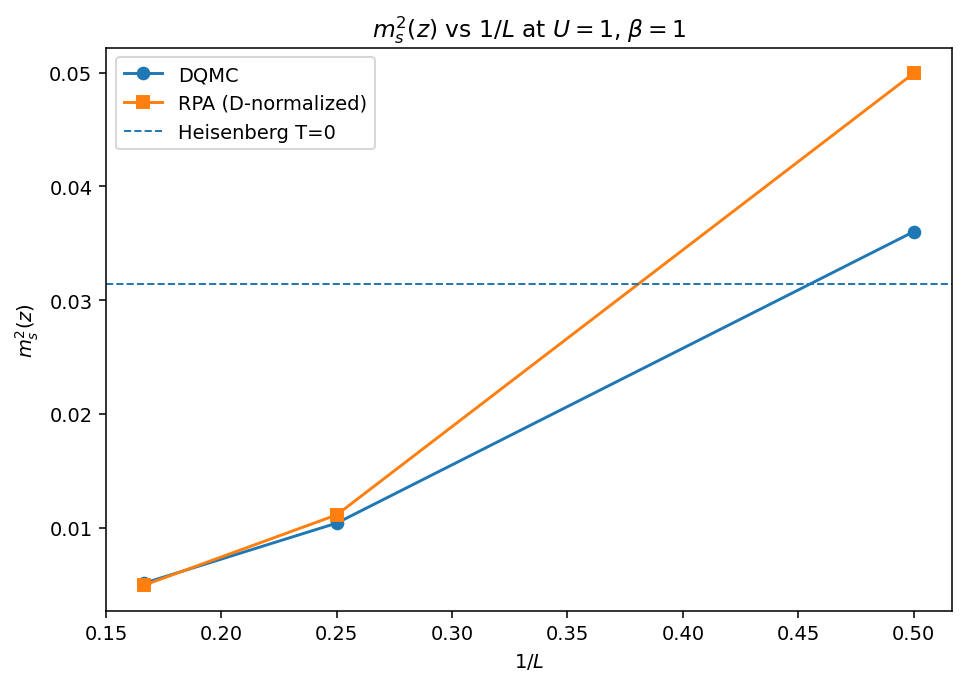

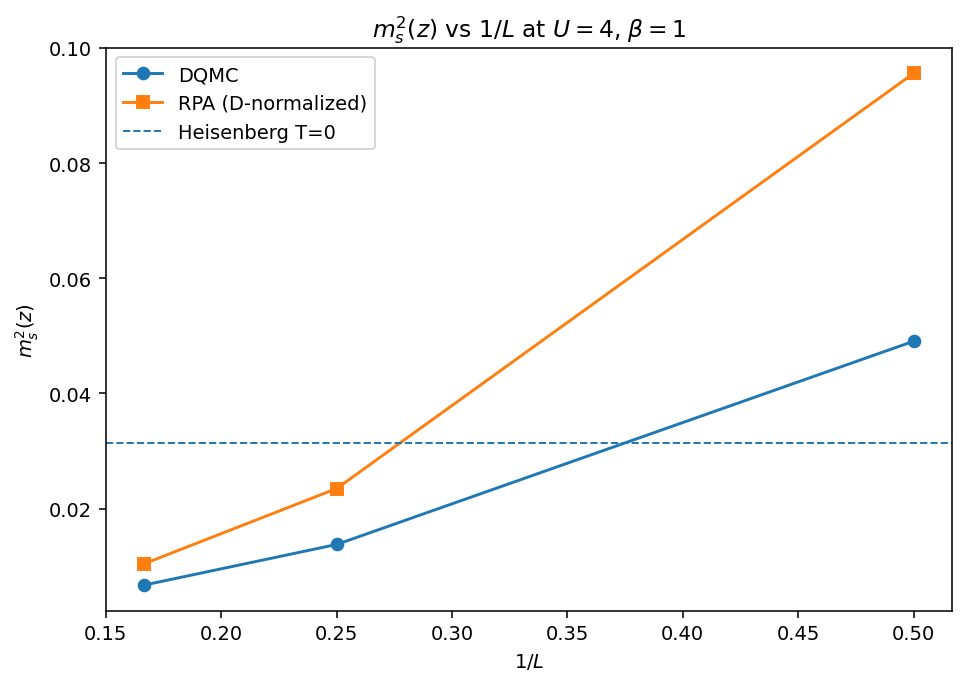

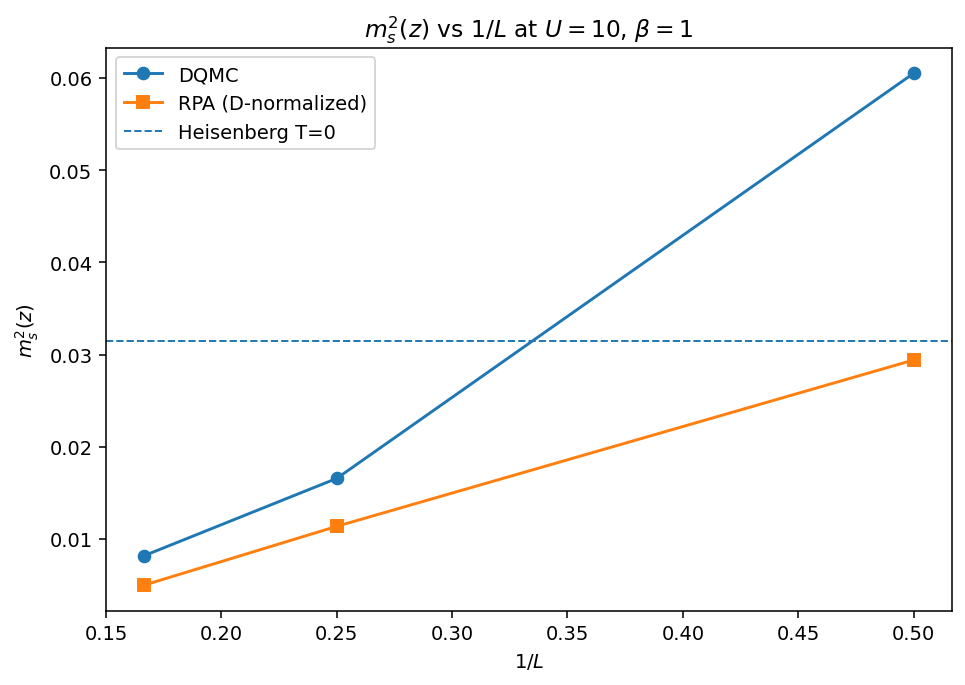

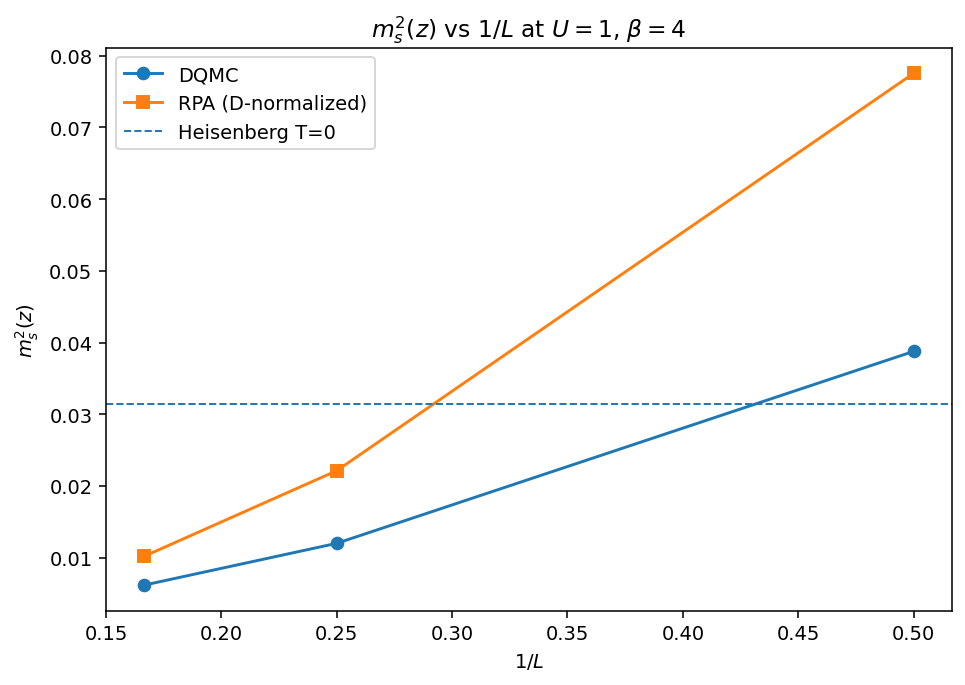

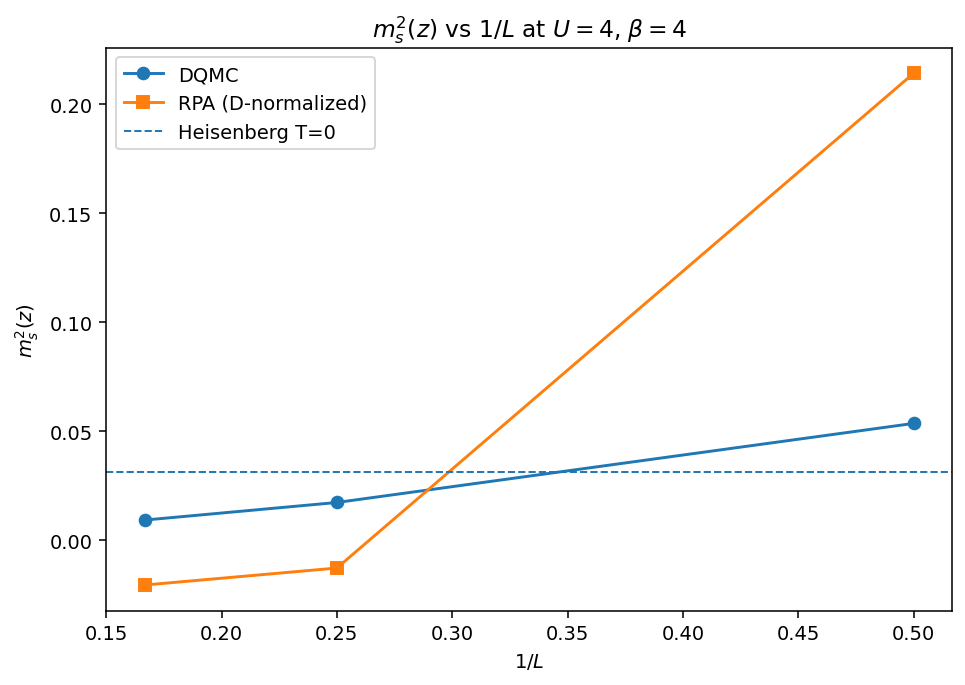

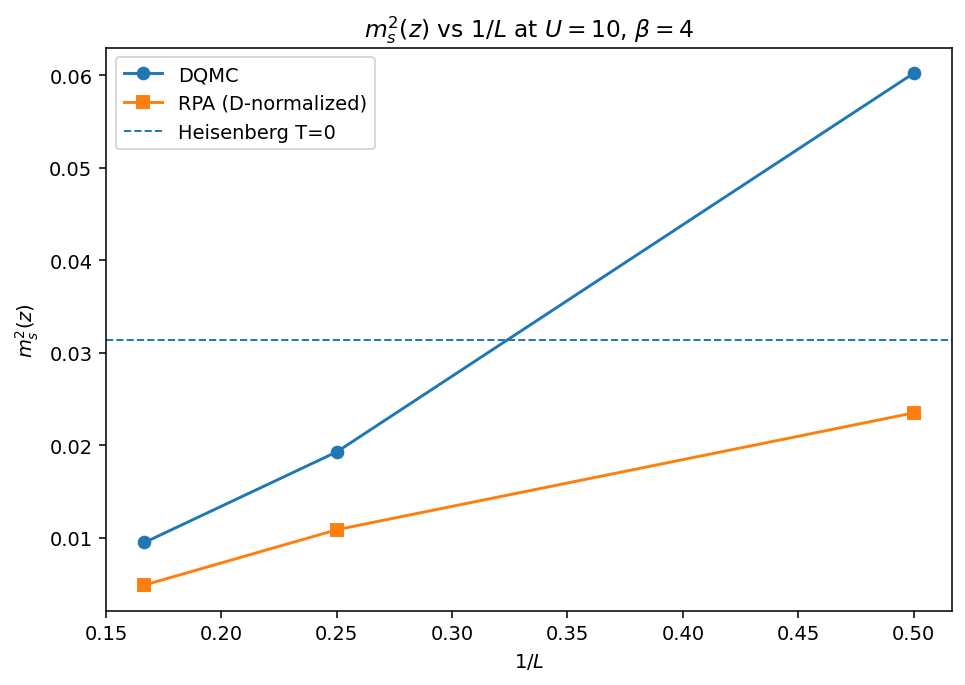

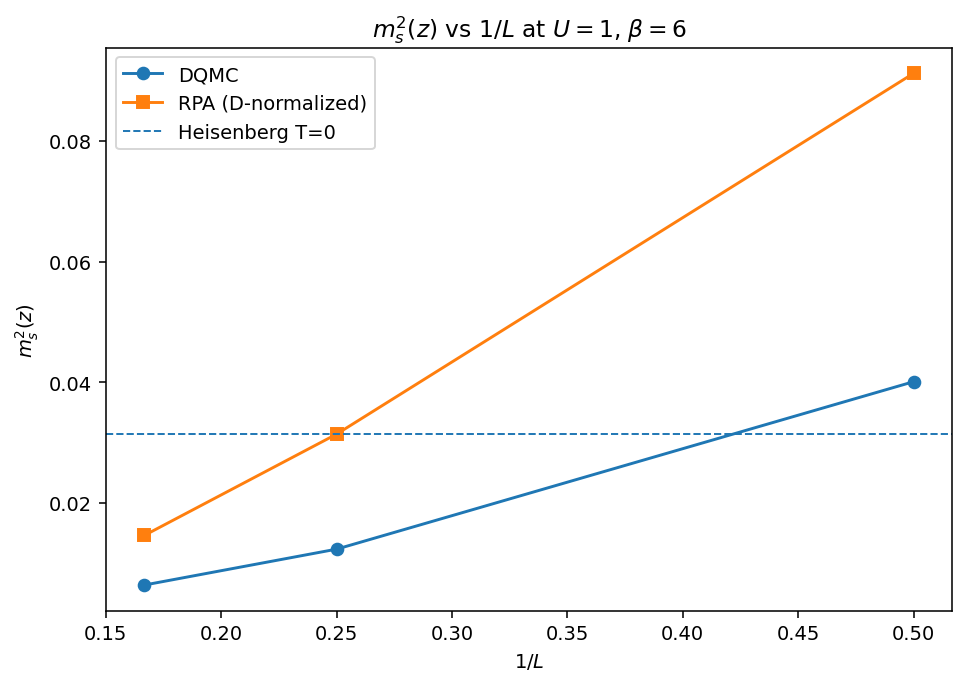

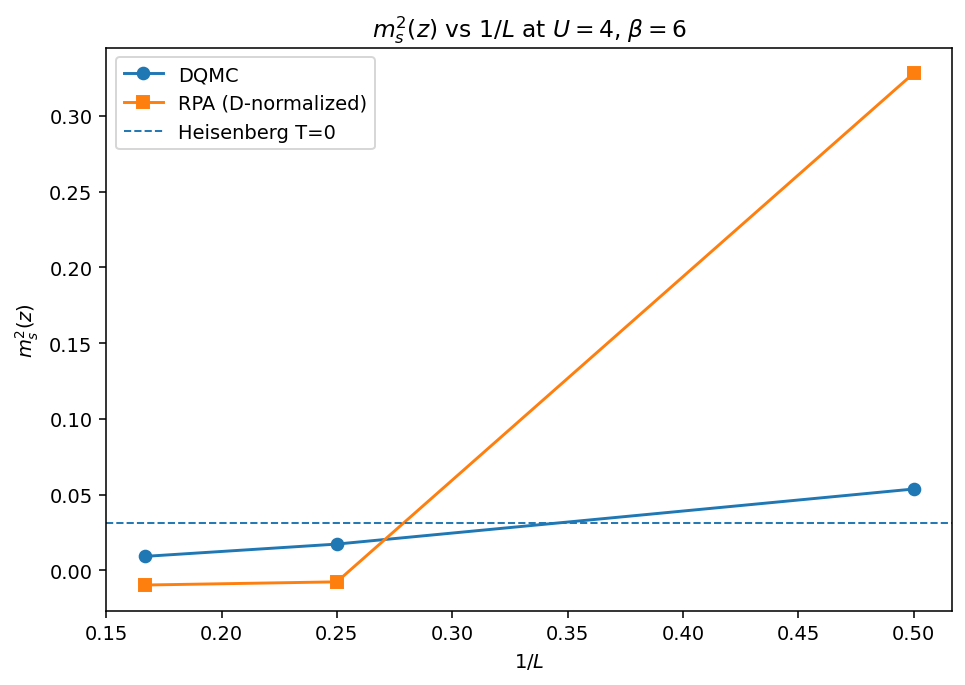

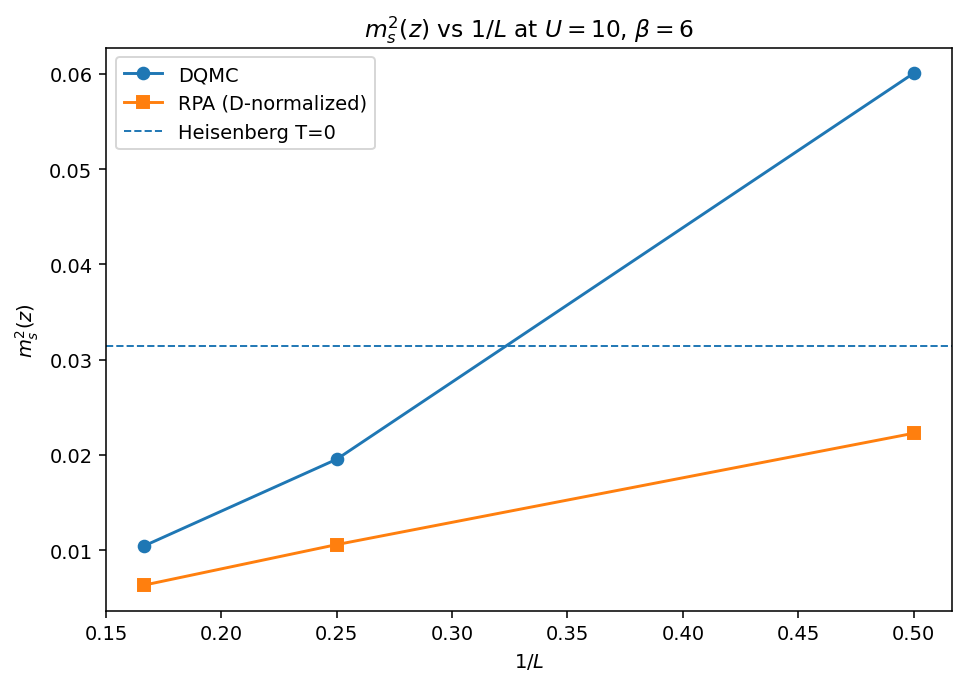

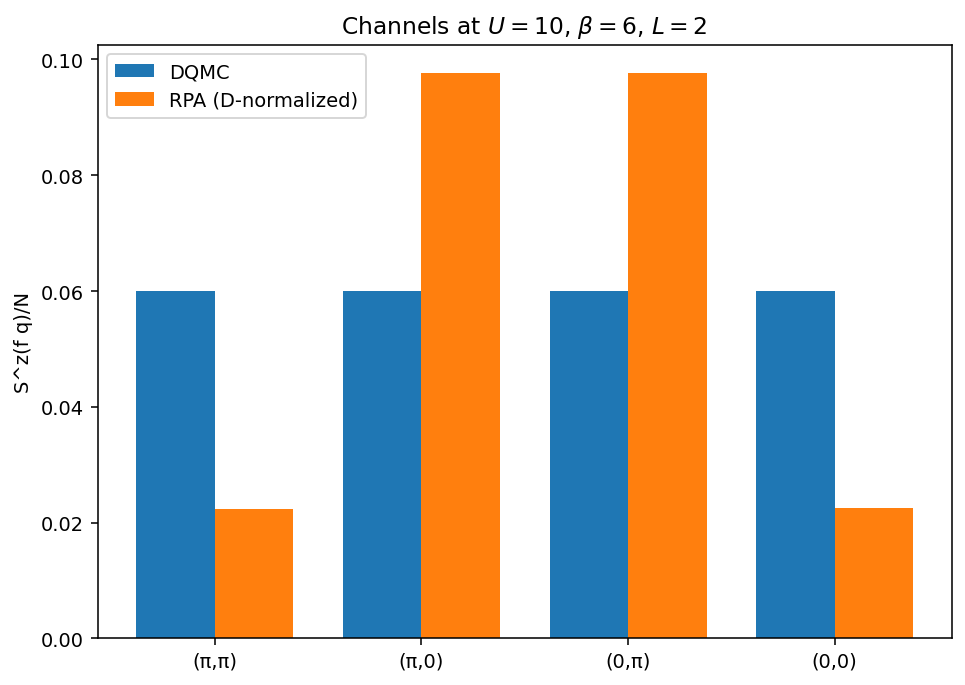

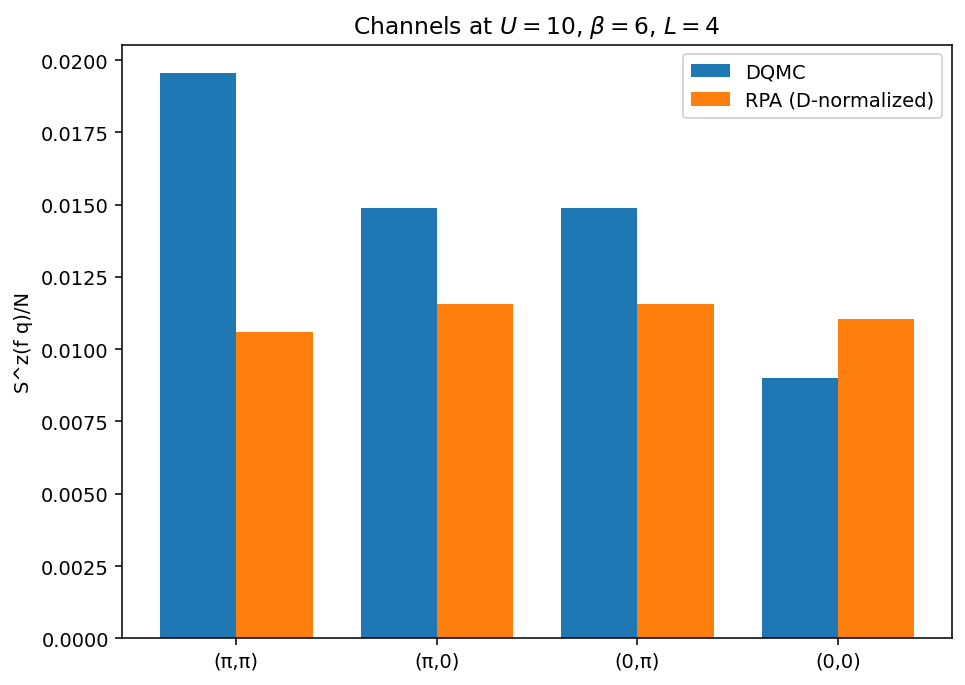

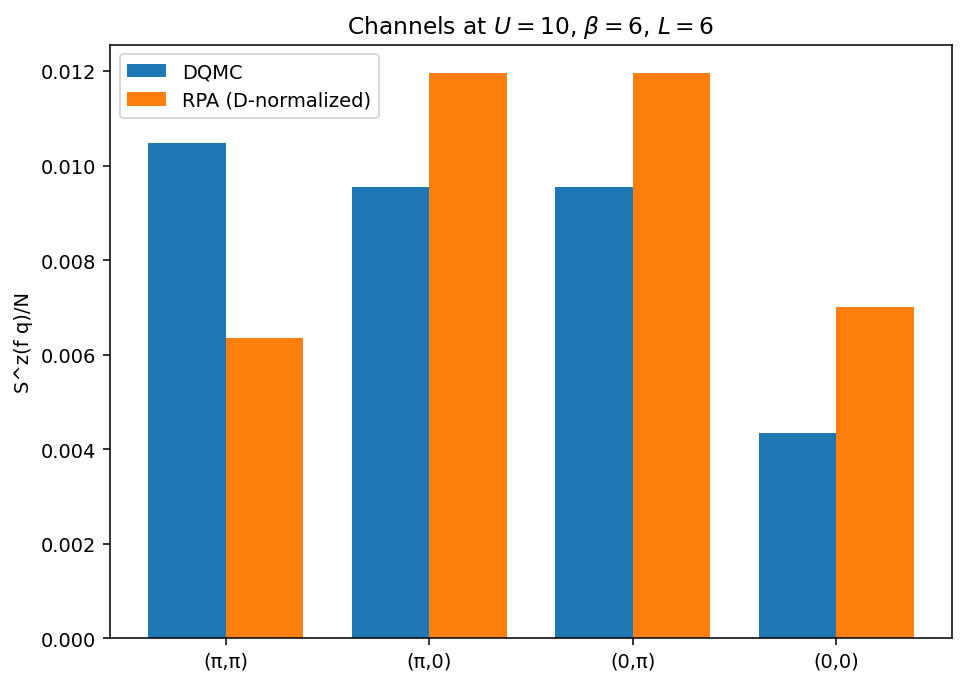

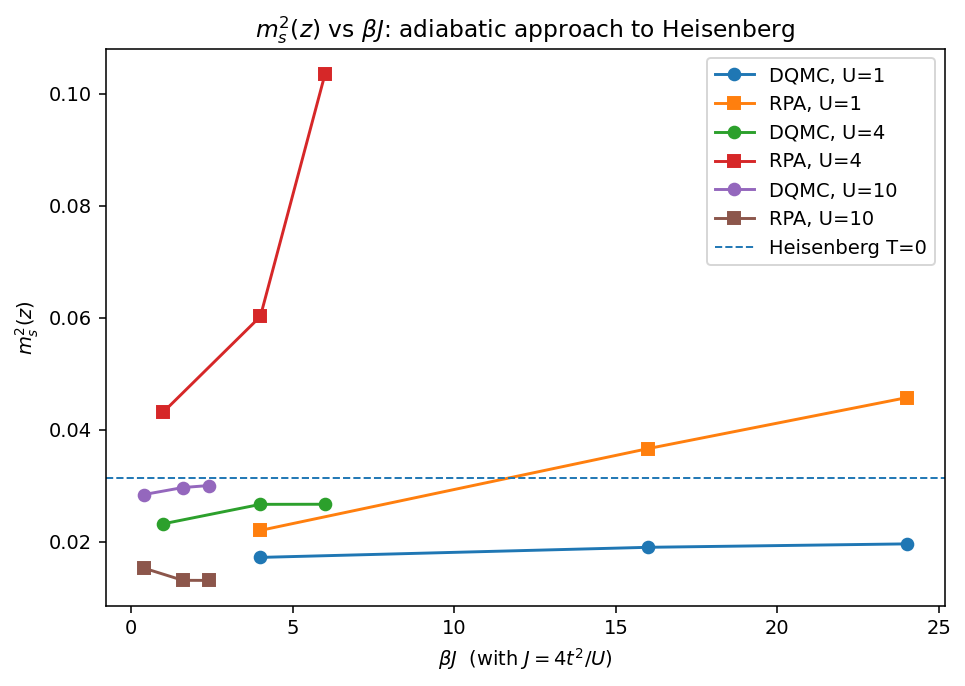

In [29]:
def plot_ms2_vs_1overL(df_cmp, fixed_beta, fixed_U):
    sub = df_cmp[(np.isclose(df_cmp['beta'], fixed_beta)) & (np.isclose(df_cmp['u'], fixed_U))].copy()
    if sub.empty:
        print(f"No data for beta={fixed_beta}, U={fixed_U}")
        return
    sub = sub.sort_values('nx')
    x = 1.0 / sub['nx'].astype(float).values
    y_dqmc = sub['ms2_z_dqmc'].values
    y_rpa  = sub['ms2_z_rpa'].values
    plt.figure(figsize=(7,5))
    plt.plot(x, y_dqmc, marker='o', label='DQMC')
    plt.plot(x, y_rpa,  marker='s', label='RPA (D-normalized)')
    plt.axhline(ms2z_heis_T0, linestyle='--', linewidth=1.0, label='Heisenberg T=0')
    plt.xlabel("$1/L$"); plt.ylabel("$m_s^2(z)$")
    plt.title(f"$m_s^2(z)$ vs $1/L$ at $U={fixed_U:g}$, $\\beta={fixed_beta:g}$")
    plt.legend(); plt.tight_layout(); plt.show()

def plot_channels_bar(df_cmp, fixed_beta, fixed_U, fixed_L):
    sub = df_cmp[(np.isclose(df_cmp['beta'], fixed_beta)) &
                 (np.isclose(df_cmp['u'], fixed_U)) &
                 (df_cmp['nx']==fixed_L)].copy()
    if sub.empty:
        print(f"No data for beta={fixed_beta}, U={fixed_U}, L={fixed_L}")
        return
    row = sub.iloc[0]
    labels = ["(π,π)","(π,0)","(0,π)","(0,0)"]
    dqmc_vals = [row['spipi_dqmc'], row['spi0_dqmc'], row['s0pi_dqmc'], row['s00_dqmc']]
    rpa_vals  = [row['Spipi_rpa'], row['Spi0_rpa'], row['S0pi_rpa'], row['S00_rpa']]
    N = int(row['n'])
    dqmc_vals = [v/N if np.isfinite(v) else np.nan for v in dqmc_vals]
    rpa_vals  = [v/N if np.isfinite(v) else np.nan for v in rpa_vals]
    x = np.arange(len(labels)); w = 0.38
    plt.figure(figsize=(7,5))
    if np.isfinite(dqmc_vals).any(): plt.bar(x - w/2, dqmc_vals, width=w, label='DQMC')
    if np.isfinite(rpa_vals).any():  plt.bar(x + w/2, rpa_vals, width=w, label='RPA (D-normalized)')
    plt.ylabel("S^z(f q)/N")
    plt.title(f"Channels at $U={fixed_U:g}$, $\\beta={fixed_beta:g}$, $L={fixed_L}$")
    plt.xticks(x, labels); plt.legend(); plt.tight_layout(); plt.show()

def plot_ms2_vs_betaJ(df_cmp, fixed_U=None):
    df = df_cmp.copy()
    plt.figure(figsize=(7,5))
    Ulist = sorted(df['u'].unique() if fixed_U is None else [fixed_U])
    for U in Ulist:
        sub = df[np.isclose(df['u'], U)]
        if sub.empty: continue
        g = sub.groupby('betaj').agg(ms2_dqmc=('ms2_z_dqmc','mean'),
                                     ms2_rpa=('ms2_z_rpa','mean')).reset_index()
        plt.plot(g['betaj'], g['ms2_dqmc'], marker='o', label=f'DQMC, U={U:g}')
        plt.plot(g['betaj'], g['ms2_rpa'],  marker='s', label=f'RPA, U={U:g}')
    plt.axhline(ms2z_heis_T0, linestyle='--', linewidth=1.0, label='Heisenberg T=0')
    plt.xlabel("$\\beta J$  (with $J=4t^2/U$)"); plt.ylabel("$m_s^2(z)$")
    plt.title("$m_s^2(z)$ vs $\\beta J$: adiabatic approach to Heisenberg")
    plt.legend(); plt.tight_layout(); plt.show()

# Generate comparisons
for beta in sorted(df_cmp['beta'].unique()):
    for U in sorted(df_cmp['u'].unique()):
        plot_ms2_vs_1overL(df_cmp, fixed_beta=beta, fixed_U=U)

# One representative channel comparison at the largest available beta and U
if len(df_cmp) > 0:
    beta_max = df_cmp['beta'].max()
    U_max = df_cmp['u'].max()
    for L in [2,4,6]:
        if (df_cmp['nx']==L).any():
            plot_channels_bar(df_cmp, fixed_beta=beta_max, fixed_U=U_max, fixed_L=L)

plot_ms2_vs_betaJ(df_cmp)


In [30]:
def load_sq_block_from_combined(txt_path: Path, Nx, Ny, U, beta):
    """Return S(q) (Ny×Nx) from combined_S_q_mean.txt for the exact set (Nx,Ny,U,beta)."""
    lines = [ln.strip() for ln in txt_path.read_text().splitlines() if ln.strip()]
    # try exact header; if floats differ by printing, fall back to tolerant search
    exact_hdr = f"S_q_mean_N{Nx}x{Ny}_U{U}_beta{beta}.csv"
    starts = [i for i, ln in enumerate(lines) if ln == exact_hdr]
    if not starts:
        # tolerant: match by regex and numeric closeness
        pat = re.compile(rf"S_q_mean_N{Nx}x{Ny}_U([\d\.]+)_beta([\d\.]+)\.csv$")
        cand = []
        for i, ln in enumerate(lines):
            m = pat.match(ln)
            if m:
                Uc, Bc = float(m.group(1)), float(m.group(2))
                if abs(Uc-U) < 1e-8 and abs(Bc-beta) < 1e-8:
                    cand.append(i)
        if not cand: return None
        start = cand[0]
    else:
        start = starts[0]
    if start+1 >= len(lines) or not lines[start+1].lower().startswith("m,n,qx,qy,s_mean"):
        return None
    Nyx = np.zeros((Ny, Nx), dtype=float)
    j = start + 2
    while j < len(lines) and not lines[j].startswith("S_q_mean_N"):
        parts = lines[j].split(",")
        if len(parts)==5:
            try:
                m = int(parts[0]); n = int(parts[1]); val = float(parts[4])
                Nyx[n, m] = val
            except: pass
        j += 1
    return Nyx

def plot_sq_heatmap(Sq, title):
    plt.figure(figsize=(5.2,4.5))
    plt.imshow(Sq, origin='lower', aspect='equal')
    plt.colorbar(label="S^z(q)")
    plt.title(title); plt.xlabel("m (qx = 2π m/Nx)"); plt.ylabel("n (qy = 2π n/Ny)")
    plt.tight_layout(); plt.show()

def compare_heatmaps(Nx, Ny, U, beta):
    if p_combined is None:
        print("combined_S_q_mean.txt not available.")
        return
    # Find D from D_map
    k = key_tuple(Nx, Ny, U, beta)
    if k not in D_map:
        print("No measured D for this parameter set; cannot normalize RPA.")
        return
    D_meas = D_map[k]
    # DQMC map
    Sq_dqmc = load_sq_block_from_combined(p_combined, Nx, Ny, U, beta)
    if Sq_dqmc is not None:
        plot_sq_heatmap(Sq_dqmc, f"DQMC S(q) | N={Nx}x{Ny}, U={U}, β={beta}")
        print("DQMC sum S(q) =", float(Sq_dqmc.sum()))
    else:
        print("No DQMC S(q) map found for this set in combined file.")
    # RPA normalized map
    chis = spin_rpa_chi(Nx, Ny, beta, U, t=1.0, mu=0.0)
    Sq_rpa, alpha = normalize_to_D(chis, D_meas, Nx, Ny)
    plot_sq_heatmap(Sq_rpa, f"RPA (D-normalized) S(q) | N={Nx}x{Ny}, U={U}, β={beta}")
    print("RPA sum S(q)  =", float(Sq_rpa.sum()), " target =", 0.25*(1-2*D_meas)*Nx*Ny)

# Example calls (uncomment to view):
# compare_heatmaps(4,4, U=4.0, beta=6.0)
# compare_heatmaps(6,6, U=10.0, beta=6.0)


In [31]:
print("Done. Files used:")
print("  summary.csv:", p_summary)
print("  ms2_summary_dnorm.csv:", p_ms2_dnorm)
print("  ms2_summary.csv:", p_ms2)
print("  combined_S_q_mean.txt:", p_combined)
print("Rows compared:", len(df_cmp))
print("Sizes L present:", sorted(df_cmp['nx'].unique()) if len(df_cmp)>0 else [])
print("β values:", sorted(df_cmp['beta'].unique()) if len(df_cmp)>0 else [])
print("U values:", sorted(df_cmp['u'].unique()) if len(df_cmp)>0 else [])


Done. Files used:
  summary.csv: summary.csv
  ms2_summary_dnorm.csv: ms2_summary_dnorm.csv
  ms2_summary.csv: None
  combined_S_q_mean.txt: combined_S_q_mean.txt
Rows compared: 27
Sizes L present: [2, 4, 6]
β values: [1.0, 4.0, 6.0]
U values: [1.0, 4.0, 10.0]
